# Import Libraries

In [1]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

/home/mosquito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# GAN

In [2]:
class DCGAN(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=128,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):
    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(
        bce(self.D_logits_real, tf.ones_like(self.D)))
    self.d_loss_fake = tf.reduce_mean(
        bce(self.D_logits_fake, tf.zeros_like(self.D_)))
    self.g_loss = tf.reduce_mean(bce(self.D_logits_fake, tf.ones_like(self.D_)))

    self.d_loss = self.d_loss_real + self.d_loss_fake

    t_vars = tf.trainable_variables()
    # get variables for generator and discriminator,
    # since they are trained separately.
    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]

    self.saver = tf.train.Saver()

  def train(self):
    #get the optimization ops
    d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.d_loss, var_list=self.d_vars)
    g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
              .minimize(self.g_loss, var_list=self.g_vars)
    init = tf.global_variables_initializer()
    self.sess.run(init)

    #generate random noise
    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    start_time = time.time()
    print('start training')
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % 2 == 0:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      # calculate the loss to monitor the training process
      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      # save the generated samples
      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image

      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(bn(conv2d(h0, self.df_dim, name='d_h1_conv')))
      h1 = flatten(h1)
      h2 = lrelu(bn(linear(h1, self.dfc_dim, 'd_h2_lin')))
      h3 = linear(h2, 1, 'd_h3_lin')

      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(bn(linear(z, self.gfc_dim, 'g_h0_lin')))

      h1 = tf.nn.relu(bn(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin')))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(bn(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2')))
      return tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

# Specifiy model checkpoint directory & samples directory

In [3]:
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

tf.reset_default_graph()

sess = tf.Session()
dcgan = DCGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


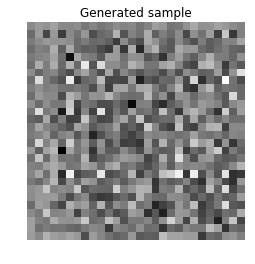

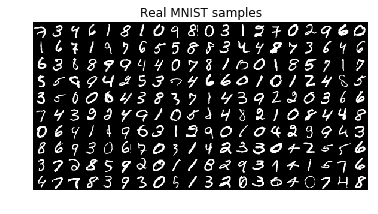

In [4]:
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = dcgan.G.eval(session=dcgan.sess, feed_dict={dcgan.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = dcgan.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

# Start traning

start training
Epoch: [ 0] time: 9.05s, d_loss: 0.9312, g_loss: 1.0835
Epoch: [ 1] time: 18.06s, d_loss: 1.1268, g_loss: 0.9448
Epoch: [ 2] time: 27.03s, d_loss: 1.1313, g_loss: 0.9115
Epoch: [ 3] time: 36.06s, d_loss: 1.1874, g_loss: 0.9197
Epoch: [ 4] time: 44.86s, d_loss: 1.1801, g_loss: 0.8276
Epoch: [ 5] time: 53.79s, d_loss: 1.1993, g_loss: 0.8539
Epoch: [ 6] time: 62.72s, d_loss: 1.1996, g_loss: 0.8339
Epoch: [ 7] time: 71.53s, d_loss: 1.1999, g_loss: 0.8263
Epoch: [ 8] time: 80.75s, d_loss: 1.1946, g_loss: 0.8327
Epoch: [ 9] time: 90.04s, d_loss: 1.1726, g_loss: 0.8445


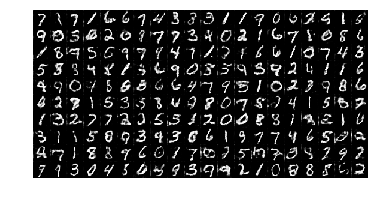

Epoch: [10] time: 99.52s, d_loss: 1.2288, g_loss: 0.8137
Epoch: [11] time: 108.78s, d_loss: 1.2056, g_loss: 0.8333
Epoch: [12] time: 118.09s, d_loss: 1.2113, g_loss: 0.8171
Epoch: [13] time: 127.22s, d_loss: 1.1845, g_loss: 0.8261
Epoch: [14] time: 136.47s, d_loss: 1.1802, g_loss: 0.8356
Epoch: [15] time: 145.63s, d_loss: 1.1973, g_loss: 0.8245
Epoch: [16] time: 154.88s, d_loss: 1.1651, g_loss: 0.8352
Epoch: [17] time: 164.07s, d_loss: 1.2400, g_loss: 0.8239
Epoch: [18] time: 173.36s, d_loss: 1.2059, g_loss: 0.8188
Epoch: [19] time: 182.57s, d_loss: 1.2552, g_loss: 0.7962


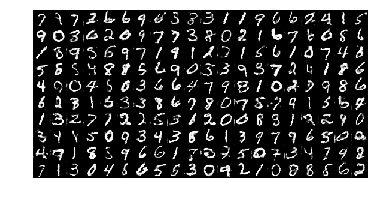

Epoch: [20] time: 192.06s, d_loss: 1.2445, g_loss: 0.8139
Epoch: [21] time: 201.26s, d_loss: 1.2582, g_loss: 0.8860
Epoch: [22] time: 210.65s, d_loss: 1.2430, g_loss: 0.8148
Epoch: [23] time: 219.86s, d_loss: 1.2579, g_loss: 0.8332
Epoch: [24] time: 229.11s, d_loss: 1.1984, g_loss: 0.8237
Epoch: [25] time: 238.44s, d_loss: 1.2460, g_loss: 0.8464
Epoch: [26] time: 247.61s, d_loss: 1.2321, g_loss: 0.8098
Epoch: [27] time: 256.82s, d_loss: 1.2015, g_loss: 0.8033
Epoch: [28] time: 266.27s, d_loss: 1.1675, g_loss: 0.8599
Epoch: [29] time: 275.44s, d_loss: 1.1558, g_loss: 0.8527


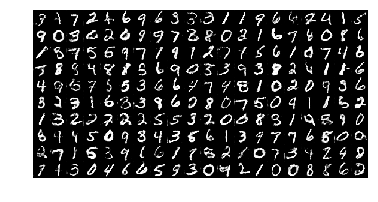

Epoch: [30] time: 284.88s, d_loss: 1.1767, g_loss: 0.8617
Epoch: [31] time: 294.08s, d_loss: 1.1757, g_loss: 0.8716
Epoch: [32] time: 303.27s, d_loss: 1.1772, g_loss: 0.8477
Epoch: [33] time: 312.68s, d_loss: 1.1486, g_loss: 0.8748
Epoch: [34] time: 321.91s, d_loss: 1.2260, g_loss: 0.8584
Epoch: [35] time: 331.10s, d_loss: 1.1882, g_loss: 0.8521
Epoch: [36] time: 340.28s, d_loss: 1.1438, g_loss: 0.8546
Epoch: [37] time: 349.65s, d_loss: 1.2061, g_loss: 0.8534
Epoch: [38] time: 358.82s, d_loss: 1.1695, g_loss: 0.8507
Epoch: [39] time: 368.00s, d_loss: 1.1967, g_loss: 0.8678


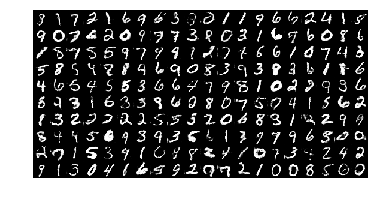

Epoch: [40] time: 377.54s, d_loss: 1.1824, g_loss: 0.8612
Epoch: [41] time: 386.72s, d_loss: 1.2088, g_loss: 0.8540
Epoch: [42] time: 395.92s, d_loss: 1.1672, g_loss: 0.8754
Epoch: [43] time: 405.11s, d_loss: 1.1462, g_loss: 0.8893
Epoch: [44] time: 414.52s, d_loss: 1.1728, g_loss: 0.8656
Epoch: [45] time: 423.86s, d_loss: 1.2178, g_loss: 0.8662
Epoch: [46] time: 432.86s, d_loss: 1.1762, g_loss: 0.8469
Epoch: [47] time: 441.51s, d_loss: 1.1702, g_loss: 0.8601
Epoch: [48] time: 450.22s, d_loss: 1.1378, g_loss: 0.8768
Epoch: [49] time: 458.98s, d_loss: 1.1454, g_loss: 0.8817


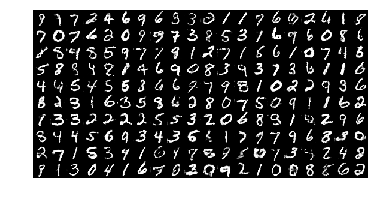

Epoch: [50] time: 467.90s, d_loss: 1.2061, g_loss: 0.8634
Epoch: [51] time: 477.25s, d_loss: 1.1213, g_loss: 0.8817
Epoch: [52] time: 486.26s, d_loss: 1.1933, g_loss: 0.8988
Epoch: [53] time: 495.29s, d_loss: 1.1341, g_loss: 0.9134
Epoch: [54] time: 504.30s, d_loss: 1.1982, g_loss: 0.9267
Epoch: [55] time: 513.34s, d_loss: 1.2202, g_loss: 0.8387
Epoch: [56] time: 522.48s, d_loss: 1.0916, g_loss: 0.9019
Epoch: [57] time: 530.92s, d_loss: 1.0892, g_loss: 0.9146
Epoch: [58] time: 540.11s, d_loss: 1.0602, g_loss: 0.9189
Epoch: [59] time: 549.49s, d_loss: 1.1124, g_loss: 0.8638


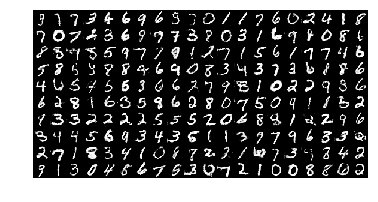

Epoch: [60] time: 558.42s, d_loss: 1.1675, g_loss: 0.9018
Epoch: [61] time: 566.78s, d_loss: 1.1662, g_loss: 0.8882
Epoch: [62] time: 575.04s, d_loss: 1.1322, g_loss: 0.8816
Epoch: [63] time: 583.32s, d_loss: 1.1123, g_loss: 0.8875
Epoch: [64] time: 591.68s, d_loss: 1.1146, g_loss: 0.9345
Epoch: [65] time: 600.07s, d_loss: 1.1374, g_loss: 0.9447
Epoch: [66] time: 608.36s, d_loss: 1.0799, g_loss: 0.9274
Epoch: [67] time: 616.82s, d_loss: 1.1726, g_loss: 0.8643
Epoch: [68] time: 625.17s, d_loss: 1.0957, g_loss: 0.8903
Epoch: [69] time: 633.43s, d_loss: 1.0419, g_loss: 0.9472


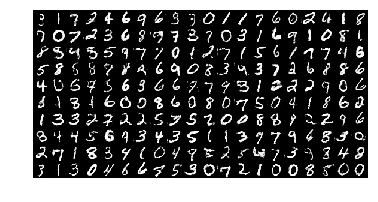

Epoch: [70] time: 641.96s, d_loss: 1.1033, g_loss: 0.9053
Epoch: [71] time: 650.21s, d_loss: 1.0978, g_loss: 0.8977
Epoch: [72] time: 658.50s, d_loss: 1.0765, g_loss: 0.9640
Epoch: [73] time: 666.79s, d_loss: 1.0661, g_loss: 0.9168
Epoch: [74] time: 675.70s, d_loss: 1.0573, g_loss: 0.9505
Epoch: [75] time: 685.11s, d_loss: 1.1061, g_loss: 0.9619
Epoch: [76] time: 694.38s, d_loss: 1.0816, g_loss: 0.9321
Epoch: [77] time: 703.53s, d_loss: 1.1457, g_loss: 0.9455
Epoch: [78] time: 712.78s, d_loss: 1.1202, g_loss: 0.9841
Epoch: [79] time: 722.07s, d_loss: 1.0684, g_loss: 0.9228


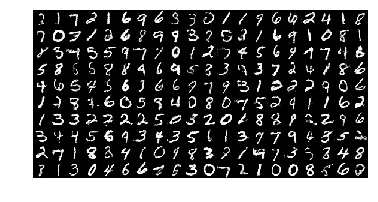

Epoch: [80] time: 731.53s, d_loss: 1.0768, g_loss: 0.9866
Epoch: [81] time: 740.85s, d_loss: 1.0975, g_loss: 0.9214
Epoch: [82] time: 750.08s, d_loss: 1.0800, g_loss: 1.0170
Epoch: [83] time: 759.38s, d_loss: 1.1071, g_loss: 0.9295
Epoch: [84] time: 768.82s, d_loss: 1.0797, g_loss: 0.9720
Epoch: [85] time: 777.99s, d_loss: 1.0190, g_loss: 0.9708
Epoch: [86] time: 787.13s, d_loss: 1.0555, g_loss: 1.0031
Epoch: [87] time: 796.24s, d_loss: 1.0744, g_loss: 0.9431
Epoch: [88] time: 805.53s, d_loss: 1.0554, g_loss: 0.9457
Epoch: [89] time: 814.81s, d_loss: 1.0892, g_loss: 0.9522


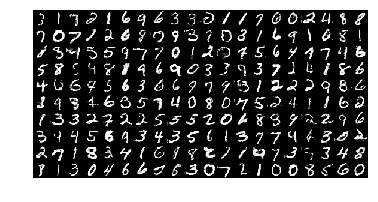

Epoch: [90] time: 824.16s, d_loss: 1.0802, g_loss: 0.9761
Epoch: [91] time: 833.41s, d_loss: 1.1127, g_loss: 0.9944
Epoch: [92] time: 842.56s, d_loss: 1.1466, g_loss: 1.0029
Epoch: [93] time: 851.78s, d_loss: 1.0104, g_loss: 1.0536
Epoch: [94] time: 861.10s, d_loss: 1.1872, g_loss: 1.0285
Epoch: [95] time: 870.24s, d_loss: 1.0824, g_loss: 1.0263
Epoch: [96] time: 879.62s, d_loss: 1.0298, g_loss: 1.0211
Epoch: [97] time: 888.53s, d_loss: 1.0577, g_loss: 0.9630
Epoch: [98] time: 896.99s, d_loss: 1.0945, g_loss: 0.9968
Epoch: [99] time: 905.70s, d_loss: 1.0233, g_loss: 1.0216


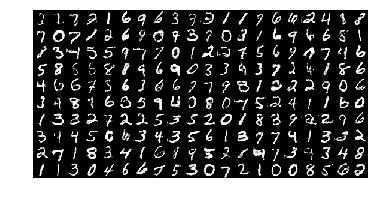

In [5]:
dcgan.train()

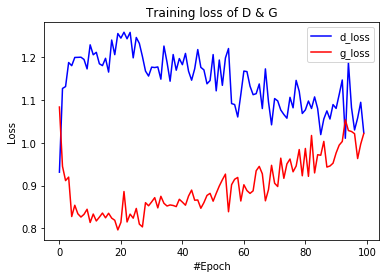

In [6]:
d_loss = dcgan.log['d_loss']
g_loss = dcgan.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [8]:
imgs = np.array(dcgan.log['gen_samples'])
make_gif(imgs * 255., 'GAN/dcgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/dcgan.gif')


[MoviePy] Building file GAN/dcgan.gif with imageio


 99%|█████████▉| 100/101 [00:01<00:00, 79.29it/s]


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/mnist_128/DCGAN.model-43001
 [*] Success to read DCGAN.model-43001


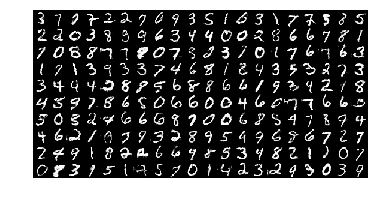

In [11]:
tf.reset_default_graph()
sess.close()

sess =tf.Session()
dcgan = DCGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,)

if not dcgan.load(checkpoint_dir)[0]:
  raise Exception("[!] Train a model first, then run test mode")

sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = dcgan.G.eval(session=dcgan.sess, feed_dict={dcgan.z: sample_z})
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
tf.reset_default_graph()
sess.close()

# Inherit from DCGAN class

In [13]:
class WGAN(DCGAN):

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    self.D, self.D_logits_real = self.discriminator(inputs)

    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    g_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
    clip_ops = []
    for var in self.d_vars:
      clip_bounds = [-.01, .01]
      clip_ops.append(
          tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
          self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

# Specifiy model checkpoint directory & samples directory

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


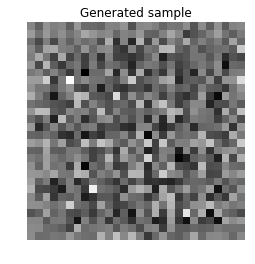

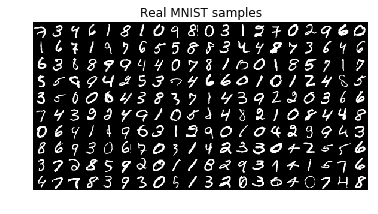

Epoch: [ 0] time: 7.59s, d_loss: 0.4617, g_loss: 0.0096
Epoch: [ 1] time: 15.05s, d_loss: 0.8422, g_loss: -0.0110
Epoch: [ 2] time: 22.40s, d_loss: 1.0860, g_loss: -0.2092
Epoch: [ 3] time: 29.83s, d_loss: 0.7697, g_loss: 0.0124
Epoch: [ 4] time: 37.09s, d_loss: 1.0160, g_loss: 0.0366
Epoch: [ 5] time: 44.59s, d_loss: 1.1328, g_loss: -0.1509
Epoch: [ 6] time: 51.97s, d_loss: 0.9979, g_loss: 0.0537
Epoch: [ 7] time: 59.40s, d_loss: 0.9612, g_loss: 0.0477
Epoch: [ 8] time: 66.69s, d_loss: 1.2209, g_loss: -0.1061
Epoch: [ 9] time: 74.13s, d_loss: 0.9562, g_loss: 0.1182


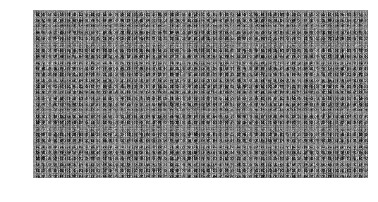

Epoch: [10] time: 81.57s, d_loss: 1.0923, g_loss: 0.1553
Epoch: [11] time: 88.94s, d_loss: 1.0162, g_loss: 0.0060
Epoch: [12] time: 96.68s, d_loss: 0.8567, g_loss: 0.1670
Epoch: [13] time: 104.74s, d_loss: 0.9839, g_loss: 0.2155
Epoch: [14] time: 112.87s, d_loss: 1.0864, g_loss: 0.0880
Epoch: [15] time: 120.98s, d_loss: 0.5870, g_loss: 0.4782
Epoch: [16] time: 129.06s, d_loss: 0.6907, g_loss: 0.4040
Epoch: [17] time: 136.44s, d_loss: 0.8518, g_loss: 0.1882
Epoch: [18] time: 143.79s, d_loss: 0.6149, g_loss: 0.3024
Epoch: [19] time: 151.17s, d_loss: 0.7782, g_loss: 0.2942


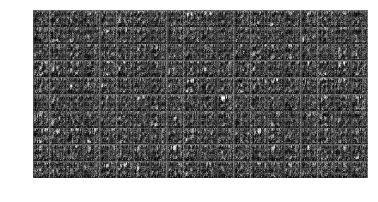

Epoch: [20] time: 158.90s, d_loss: 0.9367, g_loss: 0.1027
Epoch: [21] time: 166.15s, d_loss: 0.3415, g_loss: 0.2591
Epoch: [22] time: 173.41s, d_loss: 0.8982, g_loss: 0.1844
Epoch: [23] time: 181.28s, d_loss: 0.8506, g_loss: 0.0898
Epoch: [24] time: 189.19s, d_loss: 0.8492, g_loss: 0.2277
Epoch: [25] time: 197.02s, d_loss: 0.9101, g_loss: 0.1072
Epoch: [26] time: 204.35s, d_loss: 1.1161, g_loss: 0.0072
Epoch: [27] time: 212.09s, d_loss: 0.9291, g_loss: 0.1543
Epoch: [28] time: 220.03s, d_loss: 0.8095, g_loss: 0.2058
Epoch: [29] time: 227.74s, d_loss: 0.9402, g_loss: -0.0316


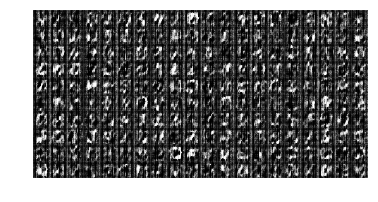

Epoch: [30] time: 235.83s, d_loss: 0.9068, g_loss: 0.1512
Epoch: [31] time: 243.96s, d_loss: 0.8926, g_loss: 0.1355
Epoch: [32] time: 252.42s, d_loss: 1.1030, g_loss: -0.0342
Epoch: [33] time: 260.47s, d_loss: 0.7467, g_loss: 0.2057
Epoch: [34] time: 268.55s, d_loss: 0.7373, g_loss: 0.1782
Epoch: [35] time: 276.52s, d_loss: 1.0293, g_loss: 0.0009
Epoch: [36] time: 284.49s, d_loss: 0.8095, g_loss: 0.1396
Epoch: [37] time: 292.44s, d_loss: 0.7158, g_loss: 0.2089
Epoch: [38] time: 300.38s, d_loss: 0.6561, g_loss: 0.0216
Epoch: [39] time: 308.38s, d_loss: 0.5924, g_loss: 0.1895


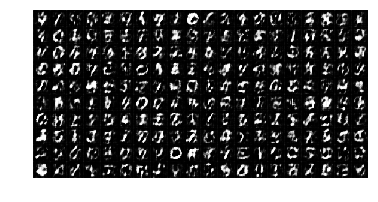

Epoch: [40] time: 316.57s, d_loss: 0.5464, g_loss: 0.2324
Epoch: [41] time: 324.49s, d_loss: 0.7863, g_loss: 0.0015
Epoch: [42] time: 332.69s, d_loss: 0.7014, g_loss: 0.1419
Epoch: [43] time: 340.90s, d_loss: 0.7878, g_loss: 0.1251
Epoch: [44] time: 348.23s, d_loss: 0.7803, g_loss: 0.0069
Epoch: [45] time: 355.71s, d_loss: 0.6082, g_loss: 0.1859
Epoch: [46] time: 363.17s, d_loss: 0.5490, g_loss: 0.1764
Epoch: [47] time: 371.18s, d_loss: 0.7704, g_loss: -0.0495
Epoch: [48] time: 379.09s, d_loss: 0.5772, g_loss: 0.1707
Epoch: [49] time: 386.91s, d_loss: 0.5509, g_loss: 0.1973


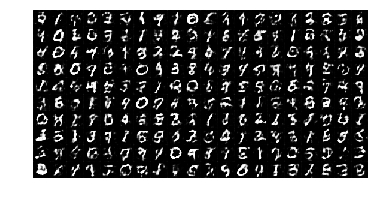

Epoch: [50] time: 394.83s, d_loss: 0.6288, g_loss: -0.0102
Epoch: [51] time: 402.37s, d_loss: 0.5521, g_loss: 0.1666
Epoch: [52] time: 409.87s, d_loss: 0.5918, g_loss: 0.0850
Epoch: [53] time: 417.34s, d_loss: 0.8068, g_loss: -0.1324
Epoch: [54] time: 424.98s, d_loss: 0.4783, g_loss: 0.1573
Epoch: [55] time: 432.80s, d_loss: 0.4496, g_loss: 0.1672
Epoch: [56] time: 440.48s, d_loss: 0.6858, g_loss: -0.1274
Epoch: [57] time: 448.02s, d_loss: 0.5386, g_loss: 0.1163
Epoch: [58] time: 455.33s, d_loss: 0.5182, g_loss: 0.0953
Epoch: [59] time: 462.62s, d_loss: 0.6270, g_loss: -0.1106


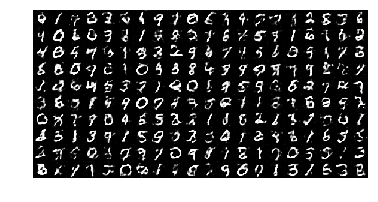

Epoch: [60] time: 470.15s, d_loss: 0.5058, g_loss: 0.1467
Epoch: [61] time: 477.56s, d_loss: 0.5575, g_loss: 0.1171
Epoch: [62] time: 484.85s, d_loss: 0.6620, g_loss: -0.1150
Epoch: [63] time: 492.14s, d_loss: 0.4538, g_loss: 0.1505
Epoch: [64] time: 499.43s, d_loss: 0.5897, g_loss: 0.0961
Epoch: [65] time: 506.75s, d_loss: 0.5784, g_loss: -0.1085
Epoch: [66] time: 514.02s, d_loss: 0.5829, g_loss: 0.0738
Epoch: [67] time: 521.57s, d_loss: 0.4944, g_loss: 0.0587
Epoch: [68] time: 528.86s, d_loss: 0.7510, g_loss: -0.2008
Epoch: [69] time: 536.32s, d_loss: 0.5210, g_loss: 0.0551


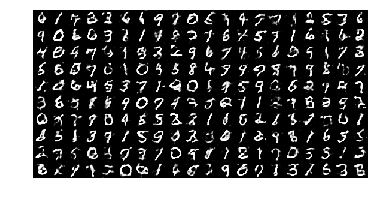

Epoch: [70] time: 543.97s, d_loss: 0.5146, g_loss: 0.0768
Epoch: [71] time: 551.40s, d_loss: 0.6455, g_loss: -0.1621
Epoch: [72] time: 558.82s, d_loss: 0.4519, g_loss: 0.1267
Epoch: [73] time: 566.09s, d_loss: 0.4378, g_loss: 0.1372
Epoch: [74] time: 573.45s, d_loss: 0.5654, g_loss: -0.0737
Epoch: [75] time: 580.83s, d_loss: 0.5413, g_loss: 0.1126
Epoch: [76] time: 588.23s, d_loss: 0.4888, g_loss: 0.0649
Epoch: [77] time: 595.48s, d_loss: 0.5306, g_loss: -0.0937
Epoch: [78] time: 602.76s, d_loss: 0.5204, g_loss: 0.0393
Epoch: [79] time: 610.02s, d_loss: 0.4537, g_loss: 0.0827


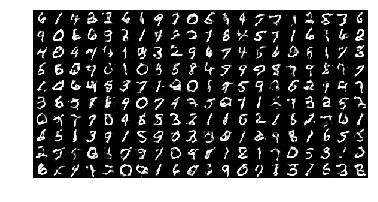

Epoch: [80] time: 617.55s, d_loss: 0.5623, g_loss: -0.1077
Epoch: [81] time: 624.78s, d_loss: 0.5198, g_loss: 0.0461
Epoch: [82] time: 632.08s, d_loss: 0.5505, g_loss: 0.0437
Epoch: [83] time: 639.40s, d_loss: 0.6103, g_loss: -0.1509
Epoch: [84] time: 646.66s, d_loss: 0.3479, g_loss: 0.0891
Epoch: [85] time: 653.92s, d_loss: 0.6076, g_loss: -0.0141
Epoch: [86] time: 661.15s, d_loss: 0.5599, g_loss: -0.1327
Epoch: [87] time: 668.45s, d_loss: 0.4507, g_loss: 0.0734
Epoch: [88] time: 675.90s, d_loss: 0.4590, g_loss: 0.0505
Epoch: [89] time: 683.53s, d_loss: 0.6198, g_loss: -0.1783


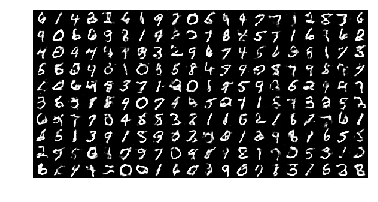

Epoch: [90] time: 691.34s, d_loss: 0.4168, g_loss: 0.0821
Epoch: [91] time: 698.90s, d_loss: 0.6009, g_loss: 0.0460
Epoch: [92] time: 706.51s, d_loss: 0.4307, g_loss: -0.0948
Epoch: [93] time: 713.98s, d_loss: 0.6055, g_loss: -0.0167
Epoch: [94] time: 721.36s, d_loss: 0.4566, g_loss: 0.0470
Epoch: [95] time: 728.75s, d_loss: 0.5036, g_loss: -0.1067
Epoch: [96] time: 736.16s, d_loss: 0.5096, g_loss: 0.0540
Epoch: [97] time: 743.58s, d_loss: 0.6196, g_loss: -0.0418
Epoch: [98] time: 751.13s, d_loss: 0.5175, g_loss: -0.1412
Epoch: [99] time: 758.86s, d_loss: 0.5151, g_loss: 0.0188


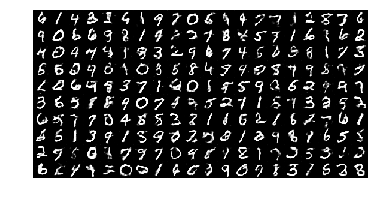

In [14]:
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = WGAN(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=128,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=100)

init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

model.train()

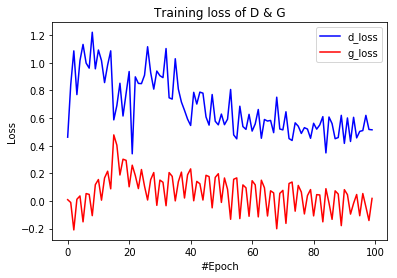

In [15]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc='upper right')
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [21]:
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')


[MoviePy] Building file GAN/wgan.gif with imageio


 99%|█████████▉| 100/101 [00:01<00:00, 63.46it/s]


In [22]:
tf.reset_default_graph()
sess.close()